In [2]:
import datetime
import random
from dateutil import parser

import re
import ast
import itertools

import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tqdm
from mpl_toolkits.mplot3d import Axes3D

import src.ftx_wrapper as ftx_api
import src.analysis as analysis
import src.io as sio

In [3]:
!heroku logs --app funding-rate-bot -n 1500 > /Users/dineshpinto/PycharmProjects/trades-bot-analysis/logs/funding-rate-bot.log

In [4]:
df, orders, stop_losses, take_profits = sio.parse_logfile("logs/funding-rate-bot.log")

In [5]:
df = sio.add_into_dataframe(df, "data/funding_rate.csv")
orders = sio.add_into_pickle(orders, "data/orders.pkl")
stop_losses = sio.add_into_pickle(stop_losses, "data/stop_losses.pkl")
take_profits = sio.add_into_pickle(take_profits, "data/take_profits.pkl")

In [6]:
df_price = ftx_api.get_historical_data(start_time=df.index[0].timestamp(), end_time=df.index[-1].timestamp())

# Realtime

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))

ax.plot(df.index, df.funding_rate, "-")
ax.tick_params(axis='y', labelcolor="tab:blue")
ax.set_ylabel("Funding Rate", color="tab:blue")

ax2 = ax.twinx()
#ax2.plot(df.index, df.price, color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.set_ylabel("Price", color="tab:orange")

ax2.plot(df_price.index, df_price.low, color="tab:orange", alpha=0.7)
ax2.plot(df_price.index, df_price.high, color="tab:orange", alpha=0.7)
ax2.fill_between(df_price.index, df_price.low, df_price.high, color="tab:orange", alpha=0.5)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

success = []

for idx, (order, stop_loss, take_profit) in enumerate(zip(orders, stop_losses, take_profits)):     
    if order["side"] == "buy":
        ax.axvline(parser.parse(order["createdAt"]), linestyle="--", color="tab:green", alpha=0.5)
    elif order["side"] == "sell":
        ax.axvline(parser.parse(order["createdAt"]), linestyle="--", color="tab:red", alpha=0.5)

    try:
        ax2.plot((parser.parse(stop_loss["createdAt"]), parser.parse(stop_losses[idx+1]["createdAt"])), 
                 (stop_loss["triggerPrice"], stop_loss["triggerPrice"]), 
                 linestyle="--", color='tab:red', alpha=0.5)
        ax2.plot((parser.parse(take_profit["createdAt"]), parser.parse(take_profits[idx+1]["createdAt"])), 
                 (take_profit["triggerPrice"], take_profit["triggerPrice"]), 
                 linestyle="--", color='tab:green', alpha=0.5)
    except Exception as exc:
        ax2.plot((parser.parse(stop_loss["createdAt"]), df.index[-1]), (stop_loss["triggerPrice"], stop_loss["triggerPrice"]),
                 linestyle="--", color='tab:red', alpha=0.5)
        ax2.plot((parser.parse(take_profit["createdAt"]), df.index[-1]), (take_profit["triggerPrice"], take_profit["triggerPrice"]), 
                 linestyle="--", color='tab:green', alpha=0.5)

ax3 = ax.twinx()
ax3.plot(df_price.index, df_price.volume, color="tab:grey", alpha=0.4)
ax3.set_ylabel("Volume")
ax3.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax3.xaxis.get_major_locator()))
ax3.set_yticks([])
ax3.set_ylabel("")

fig.tight_layout()

# Simulator

Net profit = 19.17%


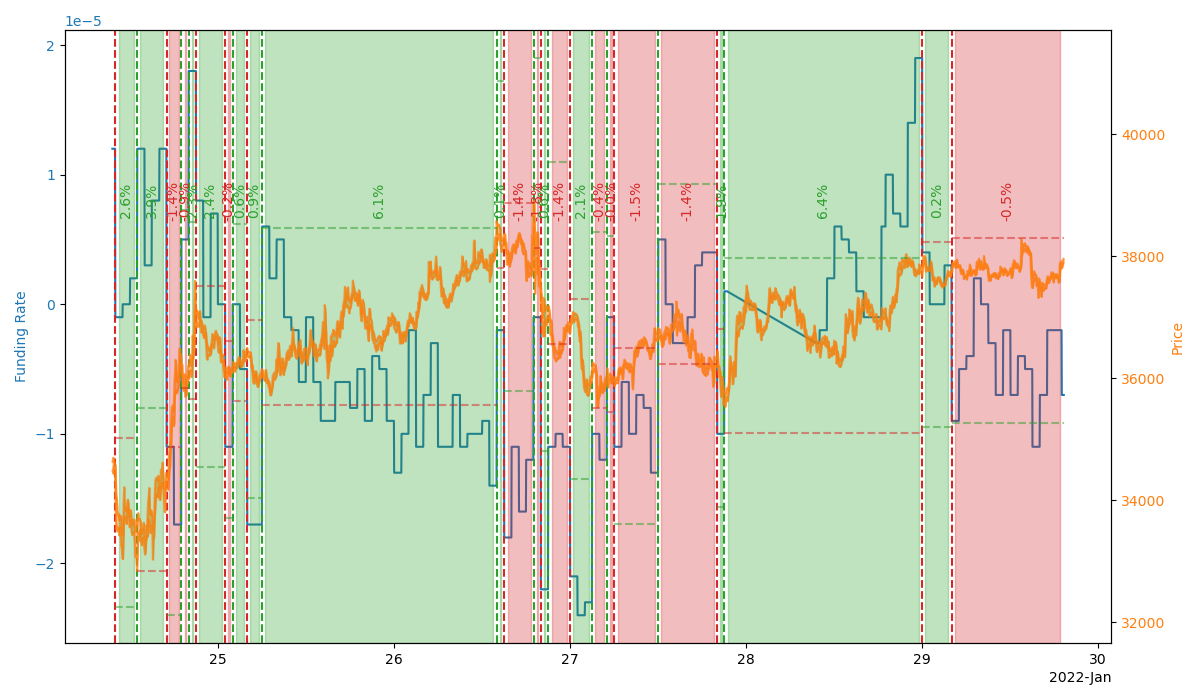

In [7]:
%matplotlib widget
fig, ax = plt.subplots(nrows=1, figsize=(12, 7))

ax.plot(df.index, df.funding_rate, "-")
ax.tick_params(axis='y', labelcolor="tab:blue")
ax.set_ylabel("Funding Rate", color="tab:blue")

ax2 = ax.twinx()
#ax2.plot(df.index, df.price, color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.set_ylabel("Price", color="tab:orange")

ax2.plot(df_price.index, df_price.low, color="tab:orange", alpha=0.7)
ax2.plot(df_price.index, df_price.high, color="tab:orange", alpha=0.7)
ax2.fill_between(df_price.index, df_price.low, df_price.high, color="tab:orange", alpha=0.5)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

target_funding_rate_change = 9.4e-4
tp_percent, sl_percent = 6.57, 1.46

order_indexes, positions, take_profits, stop_losses, profitability = analysis.test_trade_setup(target_funding_rate_change, tp_percent, sl_percent, 
                                                                                               df, df_price, ax1=ax, ax2=ax2, plot=True)
net_profit = sum(profitability)
print(f"Net profit = {net_profit:.2f}%")
fig.tight_layout()

# Optimizer

In [8]:
target_funding_rate_changes = np.linspace(5e-4, 1.5e-3, 10)
tp_percents = np.linspace(1, 7.5, 15)
sl_percents = np.linspace(1, 7.5, 15)
C = np.zeros(len(target_funding_rate_changes) * len(tp_percents) * len(sl_percents))

pbar = tqdm.tqdm(itertools.product(tp_percents, sl_percents, target_funding_rate_changes))

for idx, (tp_percent, sl_percent, target_funding_rate_change) in enumerate(pbar):
    order_indexes, positions, take_profits, stop_losses, profitability = analysis.test_trade_setup(target_funding_rate_change, tp_percent, sl_percent, 
                                                                                                   df, df_price, ax1=ax, ax2=ax2, plot=False)
    pbar.set_description(f"Total = {len(C)}")
    net_profit = sum(profitability)
    C[idx] = net_profit

Total = 2250: : 2250it [01:26, 25.89it/s]


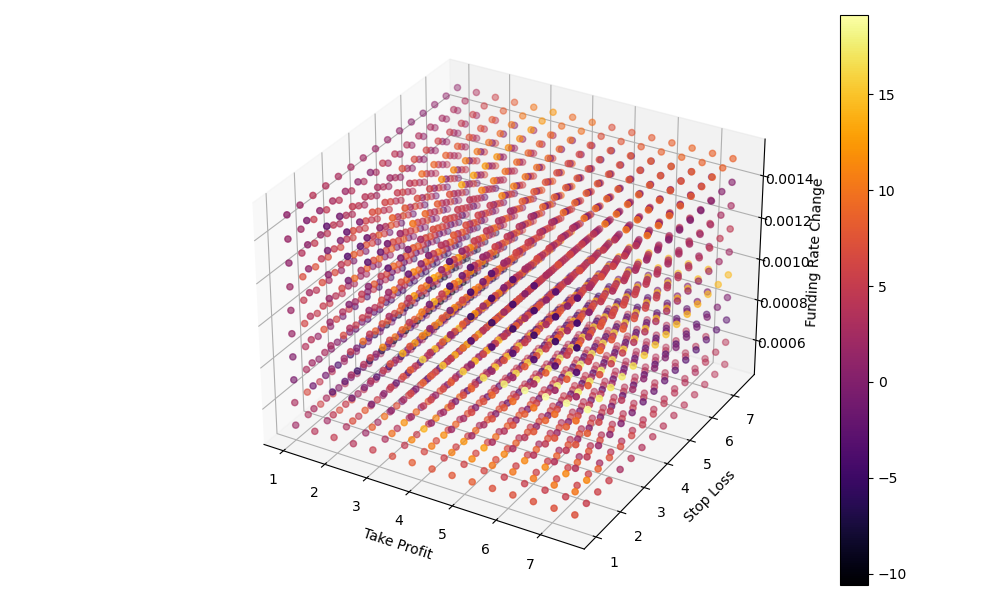

In [9]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = np.meshgrid(tp_percents, sl_percents, target_funding_rate_changes, indexing="ij")
img = ax.scatter(X, Y, Z, c=C, cmap="inferno")
ax.set_xlabel("Take Profit")
ax.set_ylabel("Stop Loss")
ax.set_zlabel("Funding Rate Change")
fig.colorbar(img)
fig.tight_layout()

In [10]:
for idx, (tp_percent, sl_percent, target_funding_rate_change) in enumerate(itertools.product(tp_percents, sl_percents, target_funding_rate_changes)):
    if idx == np.argmax(C):
        text = f"Optimal value\n" \
               f"-------------\n" \
               f"Take Profit = {tp_percent:.2f}%\n" \
               f"Stop Loss = {sl_percent:.2f}%\n" \
               f"Funding Rate Change = {target_funding_rate_change:.2e}\n" \
               f"Sum Profit = {np.max(C):.2f}%"
        print(text)
        break

Optimal value
-------------
Take Profit = 6.57%
Stop Loss = 1.46%
Funding Rate Change = 9.44e-04
Sum Profit = 19.14%
